<a href="https://colab.research.google.com/github/brenocsp/disaster-tweets/blob/main/disaster_tweets_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Linguagem Natural para Tweets sobre Desastres

Breno Claudio de Sena Pimenta

## Introdução

O Twitter é um importante meio de comunicação nos dias atuais. Nessa plataforma, é possível que diversos grupos sejam ouvidos pelo mundo todo em tempo real. Em tempos de emergência, esse meio se torna ainda mais relevante 

Por causa disso, mais agências de ajuda ou notícias estão interessadas em monitorar o Twitter. Mas nem sempre é claro se as palavras de uma pessoa estão realmente anunciando um desastre. Esse problema é originado do fato que a linguagem humana é ambígua e depende do contexto.

Sendo assim, nesse projeto será explorado o problema de classificar um conjunto de textos originados do Twitter. Esses tweets podem ser de duas classes: eles podem tratar de casos de desastres reais, ou não. Esse conjunto de dados foram classificados manualmente e disponibilizado no link a seguir.

Link: https://data.world/crowdflower/disasters-on-social-media


Exemplo:

**Desastre Real:**
> *Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn...*

**Não Desastre:**
> *I almost sent my coworker nudes on accident thank god for airplane mode*

## Importação das bibliotecas e pacotes

Nesta etapa é feita a importção de bibliotecas que serão usadas durante o trabalho.

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
!pip install nltk --quiet
!pip install pyspellchecker --quiet

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importação do dataset

Inicialmente é importado o dataset. Como pode ser visto, ele contém as seguintes colunas:

* id: um identificador para cada tweet.
* text: o texto do tweet.
* location: a localização de onde o tweet foi criado, pode ser vazio.
* keyword: uma palavra-chave que caracteriza o tweet, pode ser vazio
* target: denota se o tweet é sobre um desastre real (1) ou não (0)

In [ ]:
df_completo = pd.read_csv('https://raw.githubusercontent.com/brenocsp/disaster-tweets/main/tweets-dataset.csv')
df_completo.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Análise exploratória dos dados

Antes de prosseguir com o objetivo do trabalho, é interessante estudar sobre a composição dos dados que serão usados.

### Proporção das classes

Pode-se perceber que no conjunto de dados, 57% dos dados são da classe "não desastre", enquanto 43 são da classe "desastres reais". Logo, há uma boa proporção de dados para o treino. Essa mesma proporção será mantida ao dividir o conjunto entre teste e validação.

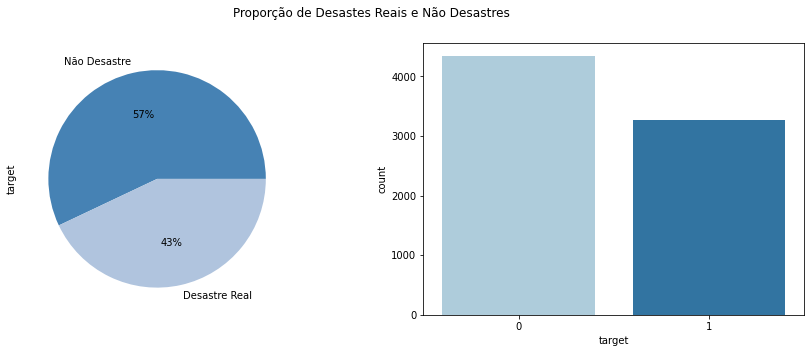

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df_completo.target.value_counts().plot(kind="pie", labels=["Não Desastre", "Desastre Real"], colors=['steelblue','lightsteelblue'], autopct='%0.0f%%')

plt.subplot(1, 2, 2)
sns.countplot(x="target", data=df_completo, palette="Paired")

plt.suptitle('Proporção de Desastes Reais e Não Desastres')

plt.show()

### Heatmap dos valores faltantes

No heatmap pode-se perceber que os dados mais faltantes são os de localização. Essa feature poderia ser utilizada para segmentar melhor os modelos de treino, já que, em cada país ou região, um modelo poderia ser treinado a fim de se entender como uma população reporta os desastres e oferecer uma solução mais personalizada. Nesse trabalho esse aspecto não será analisado por falta de valores e por baixo volume de dados.

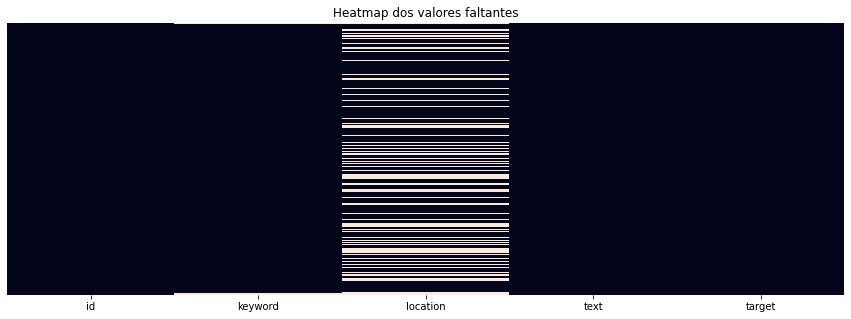

In [ ]:
fig, axes = plt.subplots(figsize=(15,5))
sns.heatmap(ax=axes, yticklabels=False, data=df_completo.isnull(), cbar=False)
axes.set_title('Heatmap dos valores faltantes')
plt.show()

 ### Contagem de caracteres

Pela contagem de caracteres, pode-se perceber que os tweeets sobre desastres reais tendem a ter mais caracteres que os não desastre. Os tweets que possuem entre 0 e 80 caracteres são mais prováveis de não serem sobre desastres. Mas, dado que o tweet tem mais de 80 e menos que 140 caracteres, não se pode concluir muito. Acima de 140 carcteres, é mais provável que seja sobre desastres reais.

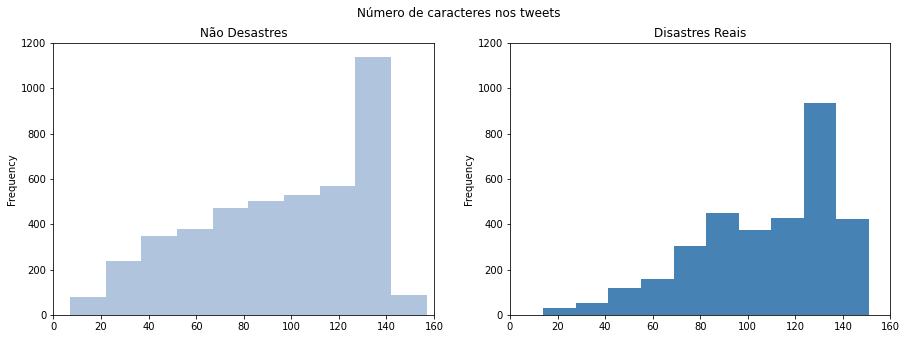

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.ylim(0, 1200)
plt.xlim(0, 160)
df_completo.query("target==0")["text"].str.len().plot(kind="hist", color="lightsteelblue", title="Não Desastres");

plt.subplot(1, 2, 2)
plt.ylim(0, 1200)
plt.xlim(0, 160)
df_completo.query("target==1")["text"].str.len().plot(kind="hist", color="steelblue", title="Disastres Reais");

plt.suptitle('Número de caracteres nos tweets')
plt.show()

### Tamanho médio das palavras

O tamanho médio das palvavras não traz informações muito relevantes. Apenas pode ser visto que a média do tamanho de palavras em tweets de desastres reais é maior que a de não desastres.

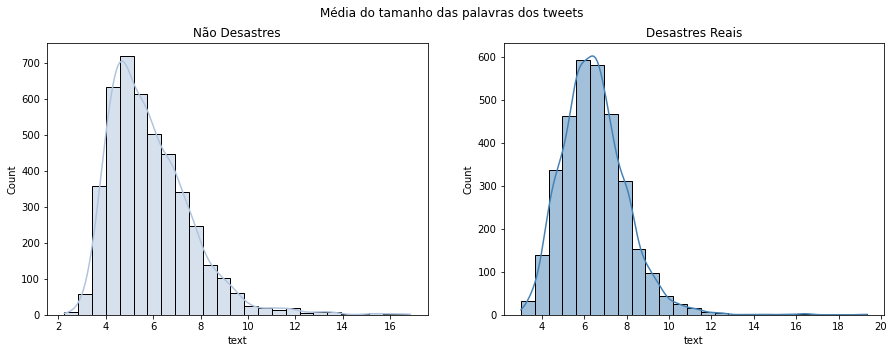

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

wordsLenght = df_completo.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(wordsLenght.map(lambda x: np.mean(x)), ax=axes[0], color='lightsteelblue', bins=25, kde=True).set_title("Não Desastres")

wordsLenght = df_completo.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(wordsLenght.map(lambda x: np.mean(x)), ax=axes[1], color="steelblue", bins=25, kde=True).set_title("Desastres Reais")

fig.suptitle('Média do tamanho das palavras dos tweets');

### Núvem de palavras

A núvem de palavras permite que uma visão qualitativa do conjunto de dados. A função a seguir realiza a criação da núvem. Pode-se perceber que os tweets sobre desastres reais possuem palavras mais negativas e violentas com mais frequencia do que os tweet sobre não desastres. Logo, pode-se confirmar que o uso do processamento de linguagem pode ser uma alternativa mais viável para classificar um tweet.


Núvem para Não Desastres:



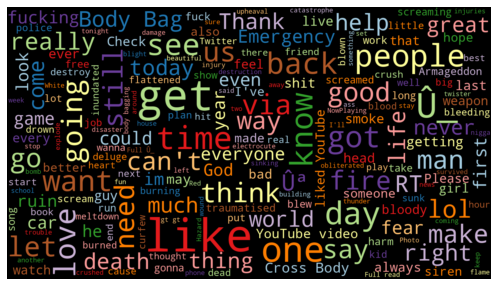


Núvem para Desastres Reais:



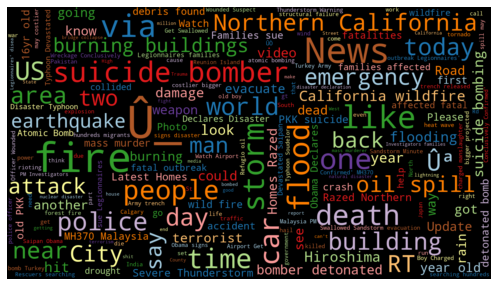

In [ ]:
stop_words= set(stopwords.words("english"))
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=1600, height=900, max_words=200, stopwords=stop_words, background_color= "black", colormap="Paired", max_font_size=150)

print('\nNúvem para Não Desastres:\n')
nonDisasterText = df_completo.query("target==0").text
nonDisasterText = nonDisasterText.str.cat(sep=" ")
wc.generate(nonDisasterText)
plt.figure(figsize=(15, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\nNúvem para Desastres Reais:\n')
disasterText = df_completo.query("target==1").text
disasterText = disasterText.str.cat(sep=" ")
wc.generate(disasterText)
plt.figure(figsize=(15, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Pré-processamento

Os dados de texto podem conter conteúdo indesejado ou sem importância o que pode dificultar a compreensão e a análise. O primeiro passo para o processamento de linguagem natural é o pré-processamento dos dados. Esse passo é essencial para criar um modelo de qualidade que gera boas previsões. Além disso, isso contribui para redução de dimensionalidade do modelo.

Não existem diretrizes precisas sobre o que deve ser feito nessa etapa, mas considerando que o texto vem do Twitter é de se esperar que as palavras estejam compactadas, contenham caracteres especiais como simbolos ou emojis, entre outros como links, nomes de outros usuários e pontuação.

Nessa etapa esse processamento é feito e um novo dataframe com os dados pré-precessados é gerado.

### Função para descontrair palavras

No inglês é comum alguns verbos serem contraídos. Essa função substitui as versões contraídas pela versão não contraída.

In [ ]:
def decontractText(text):
  text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
              .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
              .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
              .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
              .replace("he's", "he is").replace("she's", "she is").replace("'s", "is")\
              .replace("'m", "am").replace("'t", "not")\
              .replace("'ll", " will")
  
  return text

### Função para remover caracteres indesejados

Nessa função são removidos nomes de usuários, links, emojis e outros caracteres especiais que não contribuem para a análise.

In [ ]:
def removeUnwantedCharacters(text):
  whitespace = re.compile(r"\s+")
  web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
  user = re.compile(r"(?i)@[a-z0-9_]+")
  emoji = re.compile("["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"u"\U00002702-\U000027B0"u"\U000024C2-\U0001F251"
                      "]+", flags=re.UNICODE)
  
  text = whitespace.sub(' ', text)
  text = web_address.sub('', text)
  text = user.sub('', text)
  text = emoji.sub(r'', text)

  text = re.sub(r"\[[^()]*\]", "", text)
  text = re.sub("\d+", "", text)
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
  text = re.sub(r"\W+", " ", text)
  
  return text.lower()

In [ ]:
df = df_completo.copy()
df.text = [decontractText(i) for i in df.text]
df.text = [removeUnwantedCharacters(i) for i in df.text]
df

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to ishelter in place are b...,1
3,6,NaN,NaN,k people receive wildfires evacuation orders i...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,the out of control wild fires in california e...,1
7610,10871,NaN,NaN,m km s of volcano hawaii httptcozdtoydebj,1
7611,10872,NaN,NaN,police investigating after an ebike collided w...,1


### Criação de tokens

Os modelos de aprendizado de máquina usam vetores numéricos como entrada. Ao se trabalhar com texto, deve-se converter strings em números antes de usá-lo no modelo. Nessa etapa, o conteúdo já pre-processado é convertido para tokens. Assim, a etapa de pré-precessamento e preparação dos dados é finalizada.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(df.text)
vocab = tokenizer.word_index

vocabCount = len(vocab)+1
vocabCount

19265

## Processamento dos textos

Com os dados já pré-processados é possível dar início ao treino do modelo e avaliação. Inicialmente o conjunto de dados é dividido entre treino e validação, sendo que o conjunto de validação é formado por 20% dos dados totais e não participa do treino do modelo.

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df.text.to_numpy()), padding='pre')
Y = df.target.to_numpy()

x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=Y) 

### Funções auxiliares

Essas função são usadas nos experimentos a fim de facilitar a obtenção das métricas e dos gráficos.

#### Função de predição

Essa função recebe um conjunto de dados X e Y e um modelo. Ela retorna a precisão e revoção das predições.

In [ ]:
def preditionScore(x, y, model):
  y_pred = model.predict(x)
  y_pred = y_pred.reshape(len(y_pred))

  for index, prediction in enumerate(y_pred):
    if prediction > 0.9:
      y_pred[index] = 1
    else:
      y_pred[index] = 0

  accuracy = metrics.accuracy_score(y, y_pred)
  recall = metrics.recall_score(y, y_pred)

  return accuracy, recall

#### Função de validação cruzada

Essa função faz a validação cruzada kfolt com 5 partições e retorna a média da precisão e revocação no conjunto de treino e validação.

In [ ]:
def crossValidationScore(x_train, x_validation, y_train, y_validation, model, epoch=False):
  kfold = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)
  
  trainAccuracy = 0 
  trainRecall = 0
  validationAccuracy = 0
  validationRecall = 0

  for train, test in kfold.split(x_train, y_train):
    x_train_p, x_test_p = x_train[train], x_train[test]
    y_train_p, y_test_p = y_train[train], y_train[test]

    kmodel = model
    
    if epoch:
      kmodel.fit(x_train_p, y_train_p, epochs=epoch, verbose=0)
    else:
      kmodel.fit(x_train_p, y_train_p)
   
    accuracy, recall = preditionScore(x_train_p, y_train_p, kmodel)
    trainAccuracy = trainAccuracy + accuracy
    trainRecall = trainRecall+ recall

    accuracy, recall = preditionScore(x_validation, y_validation, kmodel)
    validationAccuracy = validationAccuracy + accuracy
    validationRecall = validationRecall + recall

  return trainAccuracy/5, trainRecall/5, validationAccuracy/5, validationRecall/5

#### Função para plotar gráficos

Essa função plota o gráfico das métricas para a rede neural

In [ ]:
def plotMetricsCharts(df):
  fig, axes = plt.subplots(1, 2, figsize=(15,5))
  sns.lineplot(ax=axes[0], x="Epoch", y='Treino: Acurácia', data=df, color='lightsteelblue').set_title("Acurácia")
  sns.lineplot(ax=axes[0], x="Epoch", y='Validação: Acurácia', data=df, color="steelblue")

  sns.lineplot(ax=axes[1], x="Epoch", y='Treino: Revocação', data=df, color='lightsteelblue').set_title("Revocação")
  sns.lineplot(ax=axes[1], x="Epoch", y='Validação: Revocação', data=df, color="steelblue")
  
  axes[0].set_ylabel('')
  axes[1].set_ylabel('')

  axes[0].legend(labels=["Treino", "Validação"])
  axes[1].legend(labels=["Treino", "Validação"])

  plt.suptitle('Métricas da Rede Neural')
  plt.show()

### Naive Bayers

O classificador Naive Bayes é utilizado como baseline, uma vez que é o mais simples. Abaixo temos os resultados. Com esse classificador foi possível obter  resultados iniciais no conjunto de treino e validação.

In [ ]:
model = MultinomialNB();
naiveMetrics = []

trainAccuracy, trainRecall, validationAccuracy, validationRecall = crossValidationScore(x_train, x_validation, y_train, y_validation, model)
naiveMetrics.append([trainAccuracy, trainRecall, validationAccuracy, validationRecall])

df_naive_metrics = pd.DataFrame(naiveMetrics, columns=['Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
df_naive_metrics

,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,0.589943,0.623806,0.555089,0.572477


### Decision Tree

Para o classificador de Decision Tree, o parâmetro que foi variado foi o de tamanho da árvore, incluindo o tamanho máximo. Com a árvore, o melhor resultado foi para profundidade 20, mesmo assim no conjunto de validação a acurácia não foi tão boa.

In [ ]:
model = DecisionTreeClassifier(random_state=0, max_depth=None)
trainAccuracy, trainRecall, validationAccuracy, validationRecall = crossValidationScore(x_train, x_validation, y_train, y_validation, model)

print("O tamanho máximo da árvore é: ", model.tree_.max_depth)

O tamanho máximo da árvore é:  25


In [ ]:
decisionTreeMetrics = []

for depth in [1, 5, 10, 15, 20, 25]:
  model = DecisionTreeClassifier(random_state=4, max_depth=depth)
  trainAccuracy, trainRecall, validationAccuracy, validationRecall = crossValidationScore(x_train, x_validation, y_train, y_validation, model)
  decisionTreeMetrics.append([depth, trainAccuracy, trainRecall, validationAccuracy, validationRecall])

df_tree_metrics = pd.DataFrame(decisionTreeMetrics, columns=['Profundidade', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
df_tree_metrics.sort_values('Validação: Acurácia', ascending=False).head(1)

,Profundidade,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
4,20,0.988711,0.97841,0.622587,0.560245


### k-Nearest Neighbors

Neste algoritmo foi testado algumas diferentes quantidades de vizinhos necessários para classificar um dado. O modelo performou de forma parecida com a árvore de decisão.

In [ ]:
knnMetrics = []

for neighbors in [3, 9, 15, 21]:
  model = KNeighborsClassifier(n_neighbors = neighbors)
  trainAccuracy, trainRecall, validationAccuracy, validationRecall = crossValidationScore(x_train, x_validation, y_train, y_validation, model)
  knnMetrics.append([neighbors, trainAccuracy, trainRecall, validationAccuracy, validationRecall])

df_knn_metrics = pd.DataFrame(knnMetrics, columns=['Vizinhos', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
df_knn_metrics.sort_values('Validação: Acurácia', ascending=False).head(1)

,Vizinhos,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,3,0.79142,0.714368,0.629416,0.533028


### Rede Neural

O primeiro modelo escolhido foi o modelo sequencial para união de camadas na qual cada camada tem exatamente um tensor de entrada e um tensor de saída. Esse modelo foi proposto por diversas pessoas que resolveram esse desafio na plataforma kaggle.

Esse modelo possui cinco camadas. Sendo elas:

* Camada Embedding: utiliza o vetor de vocabulário pré-processado e procura o vetor de embedding para cada índice de palavras.

* Camada Global Average Pooling: serve para gerar um mapa de features para cada categoria correspondente da tarefa de classificação na camada anterior.

* Camada Densa: esta camada é a camadas mais comumente usada em redes de redes neurais artificiais.

In [ ]:
def createNeuralModel():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(input_dim=vocabCount+1, output_dim=1, input_length=31))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
model = createNeuralModel();
neuralmetrics = []

for i in range(1,11):
  trainAccuracy, trainRecall, validationAccuracy, validationRecall = crossValidationScore(x_train, x_validation, y_train, y_validation, model, i)
  neuralmetrics.append([i, trainAccuracy, trainRecall, validationAccuracy, validationRecall])

df_neural_metrics = pd.DataFrame(neuralmetrics, columns=['Epoch', 'Treino: Acurácia', 'Treino: Revocação', 'Validação: Acurácia', 'Validação: Revocação'])
df_neural_metrics

,Epoch,Treino: Acurácia,Treino: Revocação,Validação: Acurácia,Validação: Revocação
0,1,0.570279,0.000000,0.570584,0.000000
1,2,0.570279,0.000000,0.570584,0.000000
2,3,0.583456,0.030659,0.580959,0.024159
3,4,0.678120,0.251133,0.645437,0.175535
4,5,0.782882,0.495593,0.702561,0.322018
5,6,0.860673,0.676052,0.743401,0.431193
6,7,0.912274,0.795848,0.761261,0.491437
7,8,0.948810,0.880871,0.766120,0.521713
8,9,0.970484,0.931313,0.766645,0.546177
9,10,0.983210,0.960927,0.770190,0.575229


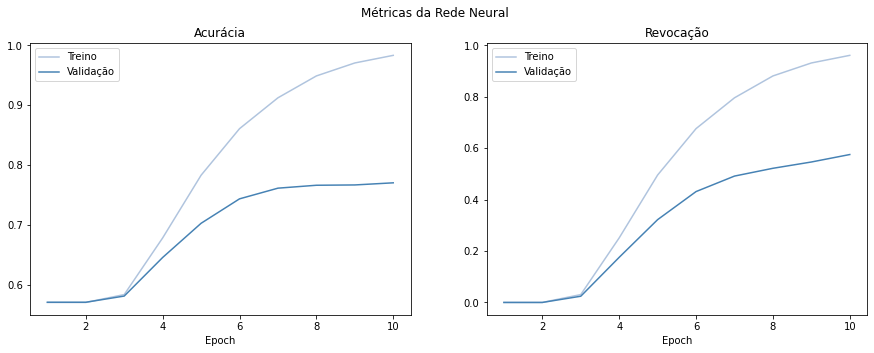

In [ ]:
plotMetricsCharts(df_neural_metrics)

Na rede neural pode-se perceber que os resultados foram bem melhores que os outros classificadores. Porém, o modelo usado atingiu um limite de acurária na validação. Talvez o modelo precisasse de mais dados ou seria melhor escolher um outro modelo com diferentes camadas para que aproveitasse melhor do conteúdo dos dados. Existem diversos modelos prontos, como o da Google, que poderiam trazer melhores resultados sem overfitting. 

## Conclusão

Nesse trabalho foi possível colocar em prática os conhecimentos sobre processamento de linguagem natural vistos na disciplina. O maior desafio do trabalho foi encontrar a melhor maneira de realizar a classificação e as técnicas de processamento do texto.

No trabalho foram exploradas técnicas de pré-processamento e criação de tokens para aprendizado de máquina. Os classificadores usados de base foram o Naive Bayers que obteve acurácia de 0,55, árvore de decisão que obteve acurária de 0,62, o kNN que obteve acurácia de 0.63 e um rede neural que obteve acurária de 0,77. Essa ultima que representa o melhor classificador utilizado.

Para melhorar ainda mais o resultado, mais modelos podem ser explorados. Outros modelos de redes neurais poderiam oferecer um resultado mais preciso. Além disso, o próprio pré-processamento poderia ser melhorado para incluir correção de ortografia e utilização de alguns simbolos especiais como fator de decisão. 

Portanto, pode-se concluir que o trabalho foi bem sucedido.


## Referências Bibliográficas
* https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
* https://www.kaggle.com/competitions/nlp-getting-started/data
* https://www.kaggle.com/code/rumbleftw/nlp-with-word-embeddings-in-tensorflow/notebook
* https://www.kaggle.com/code/rakeshku1993/eda-preprocessing-emedding-model
* https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
* https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners
* https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/
* https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8